In [1]:
from qutip import *
from matplotlib.pyplot import figure
from scipy.signal import argrelextrema
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [2]:
plt.rc('text.latex', preamble=r'\usepackage{amsmath,bbm,dsfont}')

In [3]:
# zero field splitting
Dzfs = 2*np.pi*3.471e9

# gyromagnetic ratios
gammae = 2*np.pi*2.79925e10
gammaN = 2*np.pi*3.078e6

# Fermi contact hyperfine coupling
Ahf_xx = 2*np.pi*np.array([ 79.406, 46.944, 79.406])*1e6
Ahf_yy = 2*np.pi*np.array([ 58.170, 90.025, 58.170])*1e6
Ahf_zz = 2*np.pi*np.array([ 48.159, 48.158, 48.159])*1e6
Ahf_xy = 2*np.pi*np.array([ 18.391, 0.000, -18.391])*1e6

# Normalization
units = 2*np.pi*1e6
De = Dzfs/units
ge = gammae/units
gN = gammaN/units

Axx = Ahf_xx/units
Ayy = Ahf_yy/units
Azz = Ahf_zz/units
Axy = Ahf_xy/units

A_perp = (Axx + Ayy)/np.sqrt(2)
B_perp = (Axx - Ayy)/np.sqrt(2)

AA = [Axx, Ayy, Azz, Axy, A_perp, B_perp]

In [4]:
#set gate operation time
def T(phi,a):
    if a=='z':
        return (2*(phi)/Azz.mean()) #in (2*np.pi*1e6)^-1 sec
    elif a=='x':
        return ((phi)/A_perp.mean()) #in (2*np.pi*1e6)^-1 sec 
    else:
        return ((phi)/A_perp.mean()) #in (2*np.pi*1e6)^-1 sec 
    
#set time duration with level not branch
T_z = T(np.pi,'z')

In [5]:
M = 100
fold = 1.25
M_ref = int(M//fold)
tlist = np.linspace(0, fold*T_z, M+1) # U_z

Blist1 = [0,0.1,0.5,0.7]

In [6]:
M = 100
fold = 1
tlist = np.linspace(0, fold*T_z, M+1) # U_z
K = 16*M//10
Blist = np.linspace(0, 1, K+1)

import pickle
fidel_mesh = pickle.load(open("Fidelity_Z-zy-axis_vary-B-and-t","rb"))

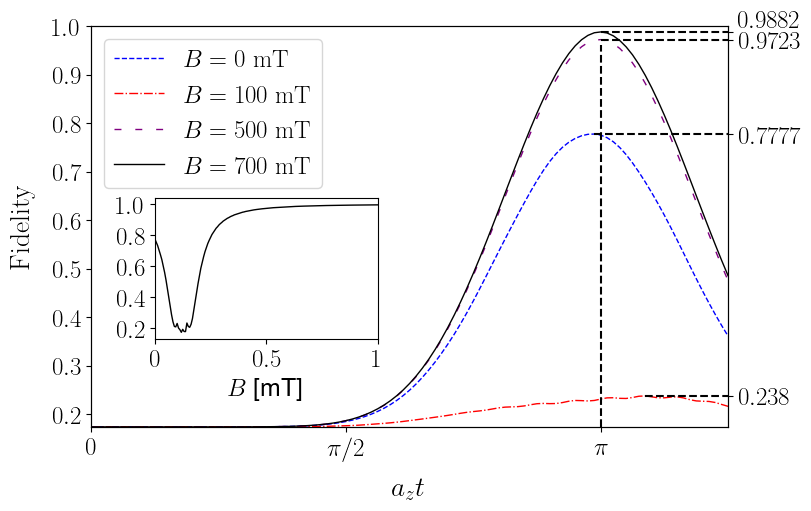

In [7]:
M = 100
fold = 1.25
M_ref = int(M//fold)
tlist = np.linspace(0, fold*T_z, M+1) # U_z
fidel_exact = pickle.load(open("Fidelity_Weyl_Z-zy-axis","rb"))

fig, axis = plt.subplots(layout='constrained',sharex=True,sharey=False,figsize=(8,5))

CR = ['b','r','purple','k']
CS = ['--', '-.',(0, (5, 10)),'-']

line = [[] for k in range(len(Blist1))]
for k in range(len(Blist1)):
    line[k], = axis.plot(tlist*Azz.mean()/2, fidel_exact[k,:], CR[k], ls=CS[k], lw=1, label=r"$B = "+str(int(Blist1[k]*1e3))+r"{~\rm mT}$")

max_list = [np.around(np.max(fidel_exact[k]),decimals=4) for k in [0,1,2]]
max_list_lab = [r'$'+str(ylab)+'$' for ylab in max_list]

axis.set_xlabel(r'$a_zt~$', fontsize=20, labelpad=10)
axis.set_xticks(np.array([0,np.pi/2,tlist[M_ref]*Azz.mean()/2]),[r'$0$',r'$\pi/2$',r'$\pi$'], fontsize=18)
axis.set_ylabel(r'$\rm Fidelity$', fontsize=20, labelpad=40)
axis.set_yticks(max_list + [np.max(fidel_exact[3])], max_list_lab + [None], fontsize=18)
axis.autoscale(enable=True, axis='x', tight=True)
axis.legend(handles=line, fontsize=18,loc='upper left')


axis3 = axis.twinx()
axis3.yaxis.tick_left()
axis.yaxis.tick_right()

ylist = [np.around(k/10,decimals=1) for k in range(1,11)]
ylist_lab = [r'$'+str(ylab)+'$' for ylab in ylist]
axis3.set_yticks(ylist, ylist_lab, fontsize=18)

axis.set_ylim(np.min(fidel_exact), 1)
axis3.set_ylim(np.min(fidel_exact), 1)



##############################################################
axis2 = axis.inset_axes([0.1, 0.22, 0.35, 0.35])

# M = 100
K = 16*M//10
Blist = np.linspace(0, 1, K+1)
axis2.plot(Blist, fidel_mesh[:,M], CR[k], ls=CS[k], lw=1, label=r"at $t=a_z^{-1}\pi$")

axis2.set_xticks(np.array([0,0.5,1]),[r'$0$',r'$0.5$',r'$1$'], fontsize=18)
axis2.set_xlabel(r'$B$ [mT]', fontsize=18, labelpad=5)

ylist = [np.around(k/5,decimals=1) for k in range(1,6)]
ylist_lab = [r'$'+str(ylab)+'$' for ylab in ylist]
axis2.set_yticks(ylist, ylist_lab, fontsize=18)
axis2.autoscale(enable=True, axis='x', tight=True)

t_ref = tlist[np.argmax(fidel_exact[3])]*Azz.mean()/2
F_max = np.max(fidel_exact[3])-0.035
axis.axvline(x=t_ref, ymin = 0, ymax = F_max, color='k', linestyle='--')
for k in [0,1,2,3]:
    axis.axhline(y = np.max(fidel_exact[k]), xmin = tlist[np.argmax(fidel_exact[k])]/np.max(tlist), xmax = 1, color='k', linestyle='--')
    
axis.text(np.max(tlist)*Azz.mean()/2 + 0.056, np.max(fidel_exact[3]) + 0.01, r'$'+str(np.around(np.max(fidel_exact[3]),decimals=4))+r'$', fontsize=18)

plt.savefig('Fig3_Fidelity_Weyl_Z-zy-axis+inset.pdf',bbox_inches='tight')